![Brown concrete building under blue sky during daytime (Sam Moghadam Khamseh)](./sam-moghadam-khamseh-s8wknXs_O7U-unsplash.jpg)

Linear models are intriguing because they are both simple and powerful. This simplicity can be attributed to the fact that many natural processes actually follow simple laws.

I'll give you an example: bigger objects are usually heavier. Both attributes are normally distributed (that is, there is an average size and mass for an object and fewer exceptions). These assumptions are what drives ordinary least squares (OLS) regression, in particular there are six key assumptions:

1. the process you are modelling is linear
2. your observations are sampled from a random variable, including noise
3. the conditional mean should be zero (variables should not have a perfect correlation)
4. there is no multi-collinearity (multiple variables should also not have a perfect correlation)
5. spherical errors: the data should be homoscedastic
6. from 5 follows that the data should be normally distributed

Linear models are also mathematically intriguing because we can translate these assumptions easily into statistics. In particular, ordinary least squares (OLS) regression can be derived simply from adding gaussian noise to a regression model:

$y = \hat{\beta}*\hat{x} + \epsilon$

Where $\epsilon$ is a gaussian random variable. When we derive this term as a function of $\beta$ and take the logarithm, we end up with the mean squared error loss criteria:

$\mathcal{L} = || y - X\beta ||^2$

Which is the **optimal** loss function for regression, given a process with gaussian noise. This is the loss function that you commonly use when you use `LinearRegression` (or by extension ridge, lasso, logistic etc.) from sklearn.

That's how far the theory goes. Being good scientists, we should investigate if linear regression actually does what we intend. 

Our assumption is that it would perform terribly on non-normal distributions (such as gamma). Does it actually?

In this experiment, I will test this assumption on the most common nineteen distributions, as taken from the [NIST distribution gallery](https://www.itl.nist.gov/div898/handbook/eda/section3/eda366.htm).
I've defined those distributions with a few common parameter definitions, e.g:
```python
from scipy import stats


distributions = {
    "normal": {
        "type": "continous",
        "parameters": [(0., 0.2), (0., 1.), (0., 5.), (-2, 0.5)],
        "function": stats.norm
    },
    ...
}
```

In [4]:
from dist import distributions

dist_names = list(distributions.keys())

In the next step we set up an evaluation process, more precisely we:

1. draw two distribution from the product of distributions
2. get a set of parameters for each distribution
3. create our label $y$, by assigning the cumulative density function to every data point, determining if the point is part of distribution $X_1$ or $X_2$
4. calculate a linear regression and compute the mean squared error
5. repeat step 2-4 for all available parameters, and calculate a mean error score

In [13]:
from itertools import product
from statistics import mean

from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

dist_errors = []

for dist1, dist2 in tqdm(product(dist_names, repeat=2), total=361):
    errors = []
    
    for p1, p2 in product(distributions[dist1]["parameters"], distributions[dist2]["parameters"]):
        d1 = distributions[dist1]["function"]
        d2 = distributions[dist2]["function"]
        
        x1 = d1.rvs(*p1, size=(1000,))
        x2 = d2.rvs(*p2, size=(1000,))

        X = np.stack((x1, x2)).reshape((1000, 2))

        y = [
            ((d1.cdf(x, *p1) + d1.cdf(y, *p1))/2)
            for (x, y) in zip(list(x1), list(x2))
        ]
        
        y = [0 if np.isnan(value) or np.isinf(value) else value for value in y]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
        reg = LinearRegression().fit(X_train, y_train)
        y_pred = reg.predict(X_test)
        error = mean_squared_error(y_test, y_pred)
        errors.append(error)

    dist_errors.append(mean(errors))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 361/361 [04:55<00:00,  1.22it/s]


We obtain a $19 \times 19$ matrix which we can visualize using a heatmap:

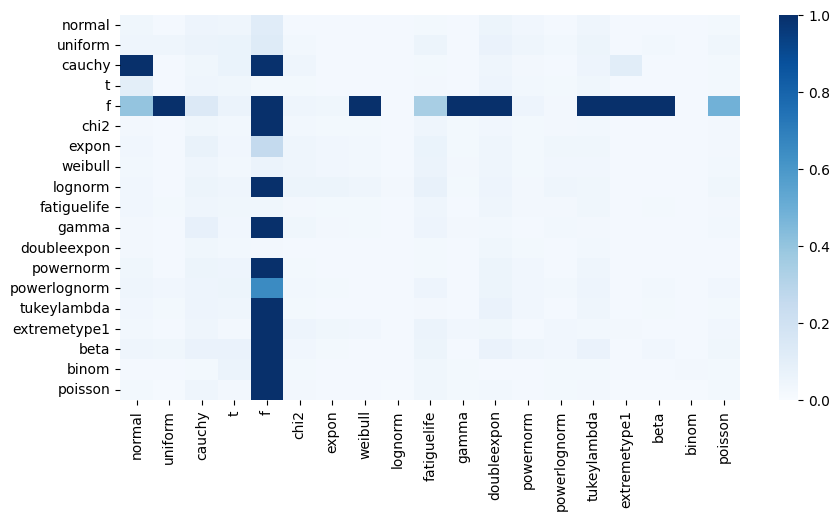

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(10, 5))

sns.heatmap(
    (np.array(dist_errors)).reshape((19, 19)),
    vmin=0,
    vmax=1,
    center=0.5,
    cmap="Blues",
    xticklabels=dist_names, 
    yticklabels=dist_names,
    ax=ax
)

plt.show()

This plot unveils the empirical side of things isn't as clear-cut as we would like to believe from the theory. Let's try to unwrap it a little bit more:

- normal distributions and anything with a logarithmic term (powernorm, lognorn, expon, chi2, lognorm etc) can be regressed
- a number of unrelated but also heteroskedastic distributions (uniform, beta, gamma, binomial, poisson) can also be regressed
- the F and cauchy distributions trick up linear regression

With this knowledge at hand, it is *less* surprising that linear models are very popular, simply because they are very robust. One doesn't need a perfectly normal sample, in fact it will work just fine on many other distributions, even when assumption *6* **and** *5* are violated.

We can continue to test linear models by dissecting wether they withstand datasets with a additional (non-gaussian) noise. To do so, we repeat our previous experiment, but instead we add a proportion of random noise. We can then model the loss in relation to this random noise.

In [63]:
import random
from scipy import stats

noise_errors = []

for i in range(1, 500):
    x1 = stats.norm.rvs(0, 0.2, size=(1000,))
    x2 = stats.norm.rvs(0, 1.0, size=(1000,))
    
    y = [
        ((stats.norm.cdf(x, 0, 0.2) + stats.norm.cdf(y, 0, 1.0))/2)
        for (x, y) in zip(list(x1), list(x2))
    ]

    X = np.stack((x1, x2)).reshape((1000, 2))
    
    noise = [(random.uniform(-5, -5), random.uniform(-5, 5)) for n in range(i * 10)]
    X = np.concat((X, noise))
    y += [random.uniform(0, 1) for n in range(i * 10)]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    reg = LinearRegression().fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    error = mean_squared_error(y_test, y_pred)
    noise_errors.append(error)

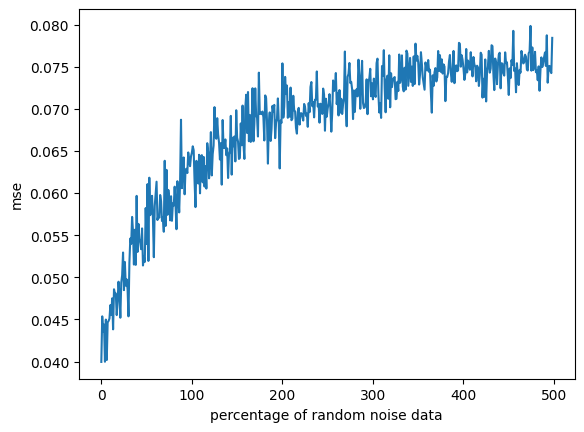

In [64]:
fig, ax = plt.subplots()
sns.lineplot(noise_errors, ax=ax)
ax.set_ylabel("mse")
ax.set_xlabel("percentage of random noise data")

plt.show()

We can see the linear regression is influenced by random noise. However, the error saturates at 300% of the data, where the model has essentially learned to ignore data that is off-distribution. Since in a more realistic scenario, we will never introduce this much noise, we can say that linear regression is also fairly robust against noise.

We will not test assumptions 3 and 4, because they are obvious. A feature with strong correlation has a related distribution. If the features are identical, OLS falls apart (becomes 0). However, if we have two identical features, we don't really need a model to begin with.

From this empiric exploration it becomes apparent why linear models are so popular:

- they are robust against noise
- they don't force assumptions, e.g: unlike a Bayesian model, they can work with all kinds of distributions
- they are really explainable (after all, its a slope and a bias)